---



## Monte Carlo Method for Portfolio Allocation
---








A Monte Carlo method is a method for simulating non-deterministic variables in order to produce meaningful results that would not be possible by deterministic options.

That is to say that we are modelling **the probability of different outcomes** that cannot be predicted since it relies on random variables. Therefore, because of the law of large numbers, as the sample size of an experiment grows, the closer we get to the average of the entire population.

- If we were to get all possible outcomes of a population (simulate them) then, in theory, it is as if we have obtained the entire populations results / outcomes.



### Portfolio Performance:

##### How does Monte Carlo Simulation work with portfolio performance?

A portfolios performance is characterized by the cumulative returns on the entire assets that have been included as a part of a portfolio. A portfolio being a basket of assets (An example of a portfolio could be having 10 companies we are investing in (AMZN, NVDA, ...)). 

We can identify certain random variables that we may want to sample from:

- Daily Spread of a stock
- The derivative price in the future.


What is important to use in this case is to run the simulation according to any relation we know previously. Using the historical data we can see **how related each of the stocks are** using the ***covariance matrix***. This represents how different assets in a portfolio move in relation to each other.

- Essentially, when running a MC simulation, we must generate random samples of asset returns that have a specific covariance structure (matching our historical data). This way we are not running a completely random simulation (with no underlying basis or understanding of how our random variables tend to behave).


Samples tend to be uncorrelated to each other, meaning that we must use something that can change this by transforming our uncorrelated random variables into correlated ones using our covariance matrix.

This is done using **Cholesky Decomposition**.

### VaR Monte Carlo Method (with Cholesky decomposition)

There are a couple of things to understand first when doing a Monte Carlo Simulation with the Cholesky decomposition.


**What is the Cholesky Decomposition of a matrix?**



A Cholesky Decomposition of a matrix is essentially a particular variant of the LU decomposition where we want to separate our matrix A, which must be square, (usually covariance matrix for risk management) to be the product of a matrix called the *Cholesky Matrix Q* by its transpose. This cholesky matrix is a lower triangular matrix (the transpose being upper triangular) and is essentially a square root of a matrix. 

- We will be applying it to the covariance matrix.

$$

A = Q \; Q^{'}

$$

*Why is the Cholesky decomposition different from the LU decomposition?*

- The Cholesky decomposition only works for Positive Semi-definite square matrices (if it is positive definite, it implies it is semi definite as well). 

- A covariance matrix is naturally symmetric therefore checking for positive definite condition means that we must check that all eigenvalues are positive.

*Why is it important that the matrix is at least positive semi-definite?*

- To ensure that we obtain a positive variance (it is a squared term, and a negative variance implies an imaginary standard deviation which is also not possible).

Note that the Variance of a portfolio is calculated as ($w$ being the weights, $V$ being the covariance matrix):

$$

V(R) = w' \; V \; w

$$


*What is Value at Risk (VaR)?*

- Value at risk is a measure of risk that estimates the potential loss in a portfolio given a certain time period (assuming normal market conditions) and also at a specific confidence level.

Therefore, we want to figure out this VaR by finding the worst losses at a specific confidence level (for example the 95th percentile).


*How do we apply this directly to the covariance matrix?*

1. Assuming a normal distribution for our random variables (our stocks) variable $Z$.

*What is the purpose of the Cholesky matrix?*

- It is used to convert non correlated random variables to correlated ones.

2. We then transform these uncorrelated standard normal random variables using a matrix $L$ that has been decomposed from our covariance matrix $\Sigma$:

$$\Sigma = LL^{T}$$

Where the L is a lower triangular matrix from our covariance matrix. We can obtain a vector $X$ (our vector of correlated random variables) to use for our simulated asset returns.

$$X = LZ$$

Therefore, our historical returns are taken into account through the covariance matrix (how related each variable is to each other).

Note that the returns simulated are ($\mu$ is for means of the returns):

$$

R_{sim} = \mu + L\cdot Z

$$

Finally, the purpose of this is to run a simulation many times to generate many returns and find the Value at Risk for the selected portfolio. (We can also generate random portfolios... which will be explained later through random selection of assets.)


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import csv
import datetime

The data to be used is the returns of each asset included in the Dow Jones 30. Not including the DOW assets which contains information only from 2019. The returns were calculated as the percentage change in the historical close data.

In [75]:
# Reading the data
return_df       = pd.read_csv("Data/return_df.csv", index_col = [0])
return_df.index = pd.to_datetime(return_df.index)

C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11584\2028124788.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return_df.index = pd.to_datetime(return_df.index)


In [76]:
return_df.columns

Index(['^DJI', 'AMZN', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS',
       'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK',
       'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WMT', 'DIS'],
      dtype='object')

In [77]:
return_portfolio = return_df.loc[:,return_df.columns!='^DJI']
return_index = return_df.loc[:, return_df.columns == '^DJI']

Getting equally weighted assets for a portfolio

In [78]:
num_assets = len(return_portfolio.columns)

# Using equally weighted portfolio weights (for simplicity)
portfolio_weights = np.zeros(num_assets) #1/ len(num_assets)
portfolio_weights += 1/num_assets
portfolio_weights



array([0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
       0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
       0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
       0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
       0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
       0.03448276, 0.03448276, 0.03448276, 0.03448276])

Covariance matrix:

- We also need to check that our matrix is positive definite (the covariance matrix). This would mean if all eigenvalues are positive.

In [79]:
def positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix))>0

In [80]:
# Covariance
A = return_portfolio.cov()

print("Covariance Matrix is Positive Definite? --> {}".format(positive_definite(A)))

# Cholesky Matrix
Q = np.linalg.cholesky(A)

# Mean for each asset return
mu_return = [np.mean(return_portfolio[each]) for each in return_portfolio.columns]

Covariance Matrix is Positive Definite? --> True


Here we are simulating a stock portfolio. So taking into account the certain stocks we have included, we can simulate the possible returns.

In [81]:
# Storing the results in a dataframe
# rows = simulation
# columns = return at simulated day

simulation_dfresults = pd.DataFrame()

In [82]:
# 1 simulation
n_simulations = 1000
days = 1000


# Generate a random variable the size of all assets
#   loc = mean, scale = std
# notice how we are sampling for each asset, days times a random variable
Z = np.random.normal(size = (num_assets,days), loc = 0, scale = 1) 

print(Z.shape)

# Now if we multiply Q by Z then we get back the simulated returns for 
# number of days
# Adjust by the cholesky factor to simulate daily returns 
X = np.dot(Q,Z)


(29, 1000)


Notice that we obtain a 29x1000 matrix where we have 29 assets and 1000 days. If we want to obtain the actual simulated returns we obviously have to multiply each simulated value of the asset to the weight for the additive return of our portfolio.

In [83]:
X.shape # 29 assets, 1000 days

(29, 1000)

In [84]:
mu_return = return_portfolio.mean()
mu_return

AMZN    0.001146
AXP     0.000643
AMGN    0.000602
AAPL    0.001083
BA      0.000503
CAT     0.000749
CSCO    0.000483
CVX     0.000395
GS      0.000652
HD      0.000783
HON     0.000503
IBM     0.000310
INTC    0.000145
JNJ     0.000358
KO      0.000409
JPM     0.000770
MCD     0.000604
MMM     0.000279
MRK     0.000513
MSFT    0.001101
NKE     0.000480
PG      0.000473
TRV     0.000542
UNH     0.000966
CRM     0.000850
VZ      0.000200
V       0.000783
WMT     0.000568
DIS     0.000182
dtype: float64

In [85]:
mu_return = return_portfolio.mean()
mean_matrix = np.full(shape=(days, num_assets), fill_value=mu_return)
mean_matrix.shape

(1000, 29)

In [86]:
def MC_simulation(ret_df, weights,n_simulations, days=1000, Q = Q):

    # We are calculating the mean of the returns
    mu_return = return_portfolio.mean()
    # creating a matrix where our columns are number of assets
    # rows are days so we are basically repeatedly putting each row as the
    # same values so we can then add them to our cholesky adjusted simulated
    # returns.
    mean_matrix = np.full(shape=(days, num_assets), fill_value=mu_return)


    # simulations

    # storing
    portfolio_simulation = np.full(shape = (days, n_simulations), fill_value=0.0)

    # Money we are starting off with (could just be 0)
    initialvalue = 1000

    for i in range(0,n_simulations):
        # Generate a random variable the size of all assets
        #   loc = mean, scale = std
        # notice how we are sampling for each asset, days times a random variable
        Z = np.random.normal(size = (days,num_assets), loc = 0, scale = 1) 

        # print(Z.shape)

        # Now if we multiply Q by Z then we get back the simulated returns for 
        # number of days
        # Adjust by the cholesky factor to simulate daily returns 
        X = np.inner(Q,Z)

        # we need the mean_matrix transpose since X is of opposite shape.
        daily_returns = mean_matrix.T + X 
        
        portfolio_simulation[:,i] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initialvalue

    return portfolio_simulation

In [87]:
sim_portf = MC_simulation(return_portfolio, portfolio_weights, n_simulations=1000)

In [88]:
sim_portf

array([[1008.29216747,  997.60554279, 1007.82711217, ...,  997.72672081,
        1007.11970726, 1005.99875982],
       [1019.45419936,  989.94778457, 1000.80638157, ..., 1005.28437152,
        1005.89930747, 1008.03608717],
       [1027.26715399,  994.99704072,  993.88670525, ..., 1018.08182652,
        1005.6551665 , 1013.84445382],
       ...,
       [2084.32255875, 1471.07495432, 2615.01414823, ..., 1227.89061442,
        1999.18806577, 1436.41459392],
       [2045.08449139, 1483.70261354, 2672.95043438, ..., 1240.66952129,
        1987.72705621, 1449.51346355],
       [2081.00409171, 1479.11255921, 2712.82293032, ..., 1266.86791724,
        1966.86577962, 1447.1192998 ]])

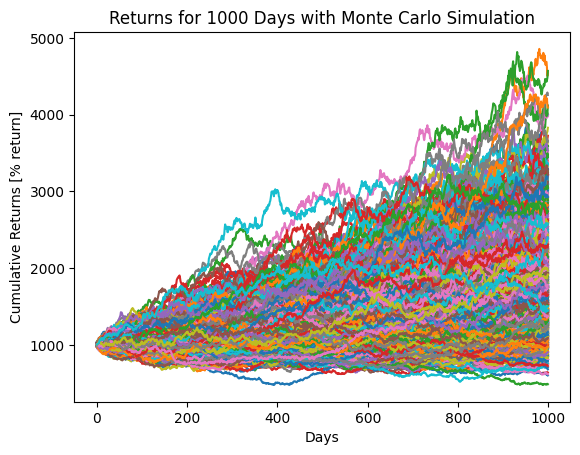

In [89]:
plt.plot(sim_portf)
plt.title('Returns for 1000 Days with Monte Carlo Simulation')
plt.xlabel('Days')
plt.ylabel('Cumulative Returns [% return]')
plt.show()

#### Calculating VaR for the simulated assets

"Value at risk is a statistic that quantifies the extent of possible financial losses within a portfolio"(investopedia.com).

- VaR is used in order to determine how much we can potential lose from a portfolio. This way we may try and reduce the risk in a portfolio according to the VaR. Although creating an optimization problem with the risk being minimized (volatility or standard deviation) may produce these results directly. None the less a monte carlo method is useful in determining information that is randomly obtained. 

This is directly the worst 5% of our returns curve / distribution.

Lets look at the lower 5th percentile of the portfolio values. This would be the amount the porfolio loses with 95% confidence level ($\alpha = 5$).

In [90]:
def var_results(sim_results=sim_portf, alpha = 0.5):
    final_row = sim_results[-1, :]
    return np.percentile(final_row, alpha)

var = var_results()

In [92]:
var

706.367971736602

What the above value is that with 95% confidence the portfolio chosen is not expected to lose more than $706.36. Therefore there is a 5% chance that the portfolio could lose more than $706.36. This corresponds to about 70% since we are starting with $1000 which is not a good value to have. We should aim to have very low VaR obviously since we want to have less risk.

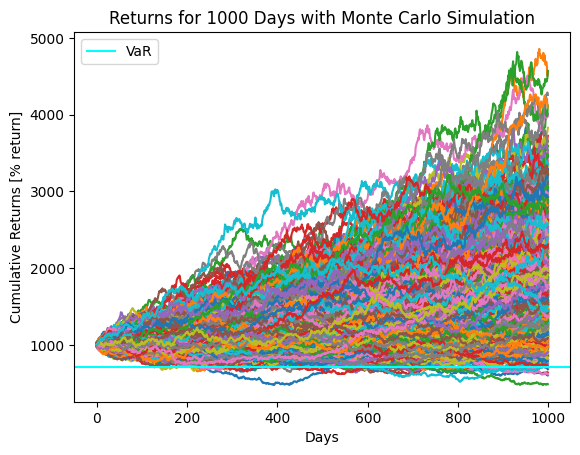

In [95]:
plt.plot(sim_portf)
plt.title('Returns for 1000 Days with Monte Carlo Simulation')
plt.xlabel('Days')
plt.ylabel('Cumulative Returns [% return]')
plt.axhline(var, color = 'cyan' , label='VaR')
plt.legend()
plt.show()

---

## Portfolio allocation and Index Tracking:

##### How can we use a Monte Carlo Simulation for generating allocating portfolio funds to track an Index?

- Here we want to create a Monte Carlo simulation for generating random portfolio allocations (all summing to 100% to get the proportion) to create a portfolio that minimizes the tracking error.


When taking into account index tracking what we actually want to do is minimize our difference in returns with relation to the index itself. That is to say that we should do the following.

$$

min \;\; (r_{\text{portfolio}} - r_{\text{index}})\\

\text{where}\quad \boxed{r_{\text{portfolio}} = \sum_{i}^{I} w_{i}\cdot r_{i}} \quad \text{for}\;\; I = \text{set of stocks.}

$$


When computing the returns, we have taken the percentage change in the closing data of each trading day (using day to day data). Therefore, when computing the returns, we are applying a form of differencing. Differencing means that we take each value and subtract it by the previous one ($y_{t} - y_{t-1}$) and this can continuosly be done. This is done in order to change a seasonal and trend-like time series into one that is non seasonal and does not include a trend. This means that we are converting the series into a stationary one (with constant mean and variance). Hence, we can use the mean and variance to compare with the index and our portfolio. This way we are including historical information into our random allocations.


Because we have differenced our data and removed seasonality / trend (using the percentage change for returns) then we now have a stationary dataset. Therefore it may be important to use the mean return for each of our stocks to find the tracking error and using the current spread (or an average of the spread around time period that is most recent).

In [97]:
index = return_df['^DJI']
portfolio = return_df.loc[:, return_df.columns!='^DJI']

**Take note** that we are using the *mean* of each stock and index. This is done since we have done the test for stationarity in which our mean is constant. Therefore comparing the means would be proper in this sense. If it were not stationary then we would need to most probably only use the mean of a certain recent time period in order to use for real time (for example).

In [98]:
def MC_sim_allocation(portfolio_df, index_df, random_spread, num_sims = 10000):

    
    results_df = pd.DataFrame(columns=portfolio_df.columns)
    tracking_error_results = []
    num_assets=len(portfolio_df.columns)

    
    spread_results = []
    portfolio_means = portfolio_df.mean()

    for i in range(0,num_sims):

        # gets the weights randomly assigned
        weights = np.random.random(num_assets) 
        # changes the weights to have a sum of 1
        weights /= np.sum(weights)
        
        # get the randomly assigned portfolio return
        portfolio_return = np.dot(weights, portfolio_means)

        # gets one value for the weighted spread
        spread = np.dot(weights, random_spread)
        # index average return
        index_return = index_df.mean()

        # average tracking error obtained.
        tracking_error = portfolio_return-index_return
    
        # adding the results of the weights to the pandas df
        results_df = results_df._append(pd.DataFrame(weights.reshape(1,-1), columns=results_df.columns), ignore_index=True)


        # adding the tracking error and spreads to the results.
        tracking_error_results.append(tracking_error)
        spread_results.append(spread)
        
    # new column with the new Tracking errors.
    results_df['TE'] = tracking_error_results
    results_df['spread'] = spread_results

    
    return results_df

Now we will be using the real-time spread given by yahoo finance. In the ask_bid.py file, it has been implemented to obtain:

- Lowest Ask (and corresponding volume)
- Highest bid (and corresponding volume)


In [100]:
def obtain_ask_bid(ticker:str)->list:

    """
        Using the ticker symbol returns:
        - bid: current real time highest bid price. (demand side of market)
        - bid size: size in volume of the bid.
        - ask: current real time lowest ask price. (supply side of market)
        - ask_size: size in volume of the ask.
    
    """
    my_stock = yf.Ticker(ticker)
    info = my_stock.info

    bid, bid_size, ask, ask_size = info['bid'], info['bidSize'], info['ask'], info['askSize']

    return bid, bid_size, ask, ask_size

def get_spread(ticker:str)->float:

    bid, bid_size, ask, ask_size = obtain_ask_bid(ticker)

    return ask-bid


Printing an example of the current spreads in the market (from yahoo finance).

In [101]:
try:
    # spreads = {each:np.abs(get_spread(str(each))) for each in r_port.columns}
    spreads = [get_spread(each) for each in portfolio.columns]
    print('New Spreads obtained as of {}:'.format(datetime.now()))
    print(spreads)

    # Proceeding to write the row onto the csv file (if we got all spreads)
    current_date = datetime.now()
    with open('Data/currentspreads.csv', 'a', newline='') as file:

        writer = csv.writer(file)
        row =spreads+[current_date]
        writer.writerow(row)

except:
    livespreads_df = pd.read_csv('Data/currentspreads.csv')
    # If the above doesnt work then just read from the csv file the last spread saved.
    last_date = livespreads_df.iloc[-1]['Date']
    spreads = livespreads_df.iloc[-1].drop('Date').tolist()
    
    print('This info is currently not available. Try some other time during active market hours.\n- Using the latest saved spreads from {}...... '.format(last_date))
    print(spreads)

This info is currently not available. Try some other time during active market hours.
- Using the latest saved spreads from 2024-08-28 20:45:48.089777...... 
[0.4000000000000057, 0.2199999999999988, 0.2999999999999545, 3.9799999999999898, 0.0699999999999931, 0.1499999999999772, 0.0900000000000034, 0.0800000000000125, 0.3700000000000045, 0.160000000000025, 0.1800000000000068, 0.0700000000000216, 0.0399999999999991, 0.0200000000000102, 0.0, -0.0100000000000193, 0.160000000000025, 0.0499999999999829, 0.0100000000000051, 0.7900000000000205, 0.0099999999999909, 0.0099999999999909, 0.3100000000000023, 0.4899999999998954, 0.1800000000000068, 0.009999999999998, 0.0500000000000113, 0.0100000000000051, 0.0100000000000051]


In [102]:
results = MC_sim_allocation(portfolio, index, random_spread = spreads)

C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11584\1052116867.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append(pd.DataFrame(weights.reshape(1,-1), columns=results_df.columns), ignore_index=True)


In [104]:
results

,AMZN,AXP,AMGN,AAPL,BA,CAT,CSCO,CVX,GS,HD,...,PG,TRV,UNH,CRM,VZ,V,WMT,DIS,TE,spread
0,0.006795,0.056479,0.020421,0.036225,0.039121,0.040135,0.005840,0.049537,0.050543,0.025975,...,0.041385,0.035230,0.035370,0.053806,0.029200,0.048887,0.023265,0.051967,0.000198,0.297423
1,0.024446,0.052080,0.006010,0.004774,0.018524,0.051121,0.050251,0.010359,0.046263,0.051010,...,0.014430,0.021889,0.046271,0.042112,0.055320,0.050849,0.024219,0.041345,0.000187,0.179792
2,0.021569,0.006484,0.027268,0.008469,0.022943,0.007502,0.042277,0.071870,0.073764,0.040510,...,0.043677,0.008236,0.018275,0.031176,0.009564,0.040724,0.034108,0.061997,0.000167,0.191865
3,0.016190,0.033762,0.021065,0.045646,0.032509,0.046789,0.011845,0.025794,0.052764,0.011545,...,0.029018,0.053051,0.025893,0.054437,0.027095,0.024017,0.003888,0.033110,0.000168,0.339292
4,0.045069,0.007589,0.021201,0.015001,0.049714,0.000345,0.056922,0.010208,0.007468,0.019447,...,0.064619,0.046421,0.033493,0.004313,0.066085,0.058467,0.037517,0.029975,0.000119,0.176593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.019731,0.000480,0.029198,0.055486,0.014691,0.020388,0.012324,0.075687,0.026948,0.052666,...,0.065932,0.070878,0.054836,0.076680,0.058864,0.015680,0.013759,0.012777,0.000195,0.369652
9996,0.065247,0.067556,0.051862,0.065075,0.039207,0.003413,0.065285,0.058005,0.001900,0.037386,...,0.051339,0.023259,0.024399,0.024845,0.051450,0.015833,0.049719,0.001492,0.000187,0.393636
9997,0.053100,0.035615,0.055444,0.052543,0.038773,0.031911,0.031219,0.042469,0.021031,0.044469,...,0.050895,0.047839,0.051569,0.001095,0.006616,0.001609,0.028003,0.042284,0.000202,0.367889
9998,0.063472,0.032551,0.022568,0.030099,0.068540,0.018554,0.049945,0.035769,0.070928,0.057048,...,0.035148,0.021909,0.011959,0.038015,0.018416,0.013849,0.032766,0.000422,0.000184,0.247074


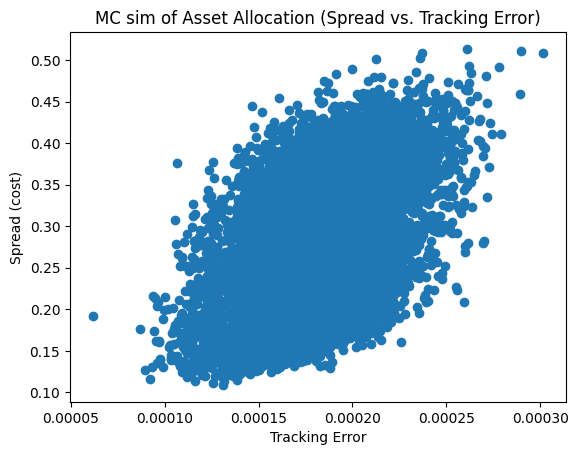

In [103]:
plt.scatter(results['TE'], results['spread'])
plt.xlabel('Tracking Error')
plt.ylabel('Spread (cost)')
plt.title('MC sim of Asset Allocation (Spread vs. Tracking Error)')
plt.show()

We can look at the distribution of excess returns

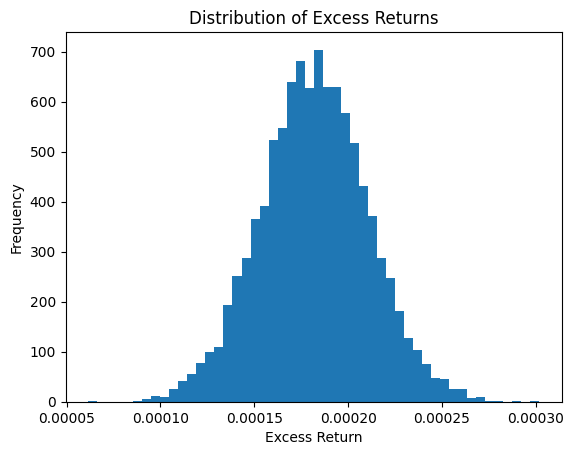

In [105]:
plt.hist(results['TE'], bins=50)
plt.title("Distribution of Excess Returns")
plt.xlabel("Excess Return")
plt.ylabel("Frequency")
plt.show()

## MC Random choosing of assets

We can also make it binary so that we can find a portfolio where we choose 0 and 1 for each of the assets, then use that to find the allocation for each of them. Therefore we have the following steps:

1. Randomly choose stocks to be used in the portfolio.

2. Randomly allocate percentage of funds to each of them.

3. Find the tracking error.

Because the above function seemed to only give 0s it may be best to do it ourselves.

In [106]:
def random_binary(length):
    rand_int_list = []
    for i in range(length):
        random_float = np.random.random()
        if random_float > .5:
            rand_int = 1

        else:
            rand_int = 0
        rand_int_list.append(rand_int)
        
    return rand_int_list

Obtaining a two lists:

1. Binary list for asset choosing.

2. Weights list for asset allocation (from the ones chosen before).

In [107]:
def obtain_random_portfolio_binary(portfolio_df):

    # defining the lists before
    

    num_assets = len(portfolio_df.columns)
    final_results = [0 for i in range(0,num_assets)]
    # now using the number of assets we can create two lists

    # 1. With just 1s and 0s randomly obtained:
    binary_list = random_binary(num_assets)


    # 2. The allocation for each of them:

    # - counting how many assets are not zero
    count_nonzero = np.sum(binary_list)

    # - getting an allocation randomly assigned
    weights = np.random.random(num_assets) 
        # changes the weights to have a sum of 1
    weights /= np.sum(weights)
    count_weights = 0
    for i in range(0,len(binary_list)):
        if binary_list[i] != 0:
            final_results[i] = weights[count_weights]
            count_weights+=1
        else:
            continue
        
    # print(binary_list)
    # print(weights)

    return np.array(binary_list), np.array(final_results)

Changing the same Monte Carlo Simulation to include binary allocations.

In [108]:
def MC_sim_allocation_binary(portfolio_df, index_df, random_spread, num_sims = 10000):

    
    results_df = pd.DataFrame(columns=portfolio_df.columns)
    tracking_error_results = []
    binary_sum_assets = []
    num_assets=len(portfolio_df.columns)

    # For a random spread variable.
    # random_spread = [np.random.random() for i in range(0,29)]
    spread_results = []
    portfolio_means = portfolio_df.mean()

    for i in range(0,num_sims):

        # CHANGED THIS TO MY CUSTOM FUNCTION! Now we can randomly have not chosen a stock (binary).
        binary_list, weights = obtain_random_portfolio_binary(portfolio_df)

        # get the randomly assigned portfolio return
        portfolio_return = np.dot(weights, portfolio_means)

        # Calculating the weighted spread.
        spread = np.dot(weights, random_spread)
        # Spread as just the sum of all spreads from chosen assets
        # spread = np.dot(binary_list,random_spread)

        # index average return.
        index_return = index_df.mean()

        # average tracking error obtained.
        tracking_error = np.abs(portfolio_return-index_return)
    
        # adding the results of the weights to the pandas df.
        results_df = results_df._append(pd.DataFrame(weights.reshape(1,-1), columns=results_df.columns), ignore_index=True)


        # adding the tracking error and spreads to the results.
        tracking_error_results.append(tracking_error)
        spread_results.append(spread)
        binary_sum_assets.append(np.sum(binary_list))

    # new column with the new Tracking errors.
    results_df['TE'] = tracking_error_results
    results_df['spread'] = spread_results
    results_df['NumAssets'] = binary_sum_assets
    
    return results_df

In [109]:
binary_portfolio = MC_sim_allocation_binary(portfolio, index, random_spread=spreads)
binary_portfolio

C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11584\2932055108.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append(pd.DataFrame(weights.reshape(1,-1), columns=results_df.columns), ignore_index=True)


,AMZN,AXP,AMGN,AAPL,BA,CAT,CSCO,CVX,GS,HD,...,TRV,UNH,CRM,VZ,V,WMT,DIS,TE,spread,NumAssets
0,0.017664,0.000000,0.000000,0.056472,0.000000,0.000000,0.000000,0.000000,0.045842,0.000000,...,0.030311,0.000000,0.038127,0.000000,0.019733,0.000000,0.014377,0.000107,0.294871,15
1,0.037399,0.033244,0.000000,0.048205,0.031546,0.063169,0.002886,0.000000,0.000000,0.000000,...,0.050981,0.000000,0.000000,0.044889,0.016599,0.000000,0.025052,0.000104,0.286530,14
2,0.000000,0.010370,0.070811,0.018555,0.000000,0.000000,0.000000,0.076927,0.007888,0.035760,...,0.000000,0.056560,0.000000,0.000000,0.000000,0.000000,0.059325,0.000106,0.179046,13
3,0.000000,0.034972,0.000000,0.000000,0.000000,0.000000,0.051189,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.051462,0.000000,0.000000,0.037540,0.000000,0.000212,0.039697,10
4,0.000000,0.000000,0.000000,0.014139,0.028420,0.000000,0.047634,0.000000,0.069412,0.000000,...,0.016331,0.010231,0.061901,0.035870,0.013789,0.029966,0.061444,0.000129,0.134637,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.034841,0.000000,0.038202,0.054241,0.057532,0.023149,0.058897,0.034884,0.026281,...,0.012104,0.032014,0.022081,0.000000,0.026551,0.055980,0.000000,0.000002,0.265330,18
9996,0.000000,0.000000,0.057672,0.036604,0.000000,0.002925,0.025555,0.054851,0.040879,0.001154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.006609,0.000000,0.000209,0.195007,13
9997,0.000000,0.006137,0.073545,0.048312,0.000000,0.000000,0.000000,0.003508,0.065081,0.028448,...,0.009853,0.000000,0.060027,0.000000,0.067147,0.000000,0.000000,0.000043,0.278830,17
9998,0.000000,0.020756,0.060835,0.000000,0.000000,0.027212,0.035470,0.011257,0.000000,0.000000,...,0.000000,0.035127,0.061406,0.068744,0.000000,0.065011,0.013973,0.000050,0.108029,17


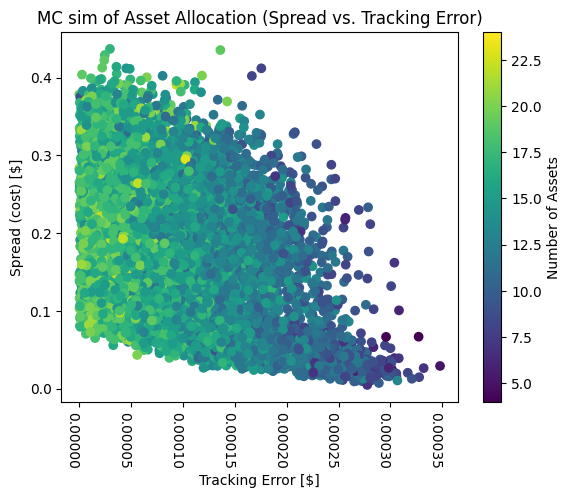

In [110]:
plt.scatter(binary_portfolio['TE'], binary_portfolio['spread'], c = binary_portfolio['NumAssets'])
plt.colorbar(label='Number of Assets')
plt.xlabel('Tracking Error [$]')
plt.ylabel('Spread (cost) [$]')
plt.xticks(rotation=-90, ha='right')
plt.title('MC sim of Asset Allocation (Spread vs. Tracking Error)')
plt.show()

Now we can see the above randomly generated portfolios and their tracking errors (using the return mean for the index) and the means of the returns of the portfolio using the weights assigned.